# Imports

In [1]:
import keras
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import gymnasium.utils.save_video

2025-04-13 12:09:08.236553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744510148.250556  141564 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744510148.254909  141564 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744510148.266272  141564 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744510148.266289  141564 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744510148.266291  141564 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
rng = np.random.default_rng()

In [4]:
def get_name(prefix: str | None, suffix: str | None, separator: str = '_') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

# Environment

Create the [environment](https://gymnasium.farama.org/environments/box2d/bipedal_walker/).

In [76]:
batch_size = 64

In [77]:
train_env = gym.make_vec("BipedalWalker-v3", hardcore=False, render_mode="rgb_array", num_envs=batch_size)
valid_env = gym.make_vec("BipedalWalker-v3", hardcore=False, render_mode="rgb_array", num_envs=batch_size)

In [78]:
num_states = train_env.single_observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = train_env.single_action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = train_env.single_action_space.high[0]
lower_bound = train_env.single_action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  24
Size of Action Space ->  4
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


# Replay Buffer

Create a replay buffer to hold game history

In [79]:
class ReplayBuffer:

    def __init__(self, max_size: int, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, seed: int | None = 42):
        """Stores the replay history with a maximum of `max_size` entries, removing old entries as needed.

        Parameters:
            max_size: maximal number of entries to keep
            observation_space: specification of the observation space
            action_space: specification of the action space
            seed: seed to initialize the internal random number generator for reproducibility"""

        self.current_observations = np.zeros((max_size, *observation_space.shape), dtype=observation_space.dtype)
        self.next_observations = np.zeros((max_size, *observation_space.shape), dtype=observation_space.dtype)
        self.actions = np.zeros((max_size, *action_space.shape), dtype=action_space.dtype)
        self.rewards = np.zeros((max_size,), dtype=np.float32)
        self.dones = np.zeros((max_size,), dtype=np.float32)
        
        self.max_size = max_size
        self.rng = np.random.default_rng(seed=seed)
        self.buffer_pointer = 0
        self.current_size = 0
        
    def add(self, current_observations: np.ndarray, actions: np.ndarray, rewards: np.ndarray, next_observations: np.ndarray, dones: np.ndarray) -> None:
        """Add a new entry to the buffer.

        Parameters:
            current_observations: environment state observed at the current step
            actions: action taken by the model
            rewards: reward received after taking the action
            next_observations: environment state obversed after taking the action
            dones: whether the episode has ended or not"""

        batch_size = current_observations.shape[0]
        idxs = (np.arange(batch_size) + self.buffer_pointer) % self.max_size

        self.current_observations[idxs] = current_observations
        self.actions[idxs] = actions
        self.rewards[idxs] = rewards
        self.next_observations[idxs] = next_observations
        self.dones[idxs] = dones

        self.buffer_pointer = (idxs[-1] + 1) % self.max_size
        self.current_size = min(self.max_size, self.current_size + batch_size)
    
    def sample(self, n_samples: int, replace: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Randomly samples `n_samples` from the buffer.

        Parameters:
            n_samples: number of samples to select
            replace: sample with or without replacement

        Returns:
            current observations, actions, rewards, next observations, dones"""

        return self[self.rng.choice(self.current_size, size=n_samples, replace=replace)]

    def clear(self) -> None:
        """Clears the buffer"""

        self.buffer_pointer = 0
        self.current_size = 0

    def __getitem__(self, index: int | np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Gets a sample at `index`

        Parameters:
            index: index of the sample to get

        Returns:
            current observations, actions, rewards, next observations, dones"""

        return (
            self.current_observations[index],
            self.actions[index],
            self.rewards[index],
            self.next_observations[index],
            self.dones[index]
        )
        
    def __len__(self) -> int:
        """Returns the number of entries in the buffer"""

        return self.current_size

# Model

Implement your model

In [80]:
def get_actor(
    observation_space: int,
    action_space: int,    
    features: int,
    blocks: int, 
    activation: str | keras.layers.Activation | None = 'relu',
    name: str | None = None,
):
    inputs = x = keras.layers.Input((observation_space,), name=get_name(name, 'input'), dtype=tf.int32)

    for i in range(blocks):
        x = keras.layers.Dense(features, name=get_name(name, f'dense_{i}'))(x)
        x = keras.layers.BatchNormalization(name=get_name(name, f'batch-norm_{i}'))(x)
        x = keras.layers.Activation(activation=activation, name=get_name(name, f'activation_{i}'))(x)
        
        features = features // 2
        
    
    outputs = keras.layers.Dense(action_space, activation="tanh", name=get_name(name, f'output'))(x)

    model = keras.Model(inputs, outputs)

    return model

In [81]:
def get_critic(
    observation_space: int,
    action_space: int,    
    features: int,
    blocks: int, 
    activation: str | keras.layers.Activation | None = 'relu',
    name: str | None = None,
):
    state_input = keras.layers.Input(shape=(observation_space,), name=get_name(name, 'state_input'))
    state_out = keras.layers.Dense(32, activation=activation, name=get_name(name, 'state_dense'))(state_input)

    action_input = keras.layers.Input(shape=(action_space,), name=get_name(name, 'action_input'))
    action_out = keras.layers.Dense(32, activation=activation, name=get_name(name, 'action_dense'))(action_input)

    x = keras.layers.Concatenate(name=get_name(name, 'concat'))([state_out, action_out])

    for i in range(blocks):
        x = keras.layers.Dense(features, name=get_name(name, f'dense_{i}'))(x)
        x = keras.layers.BatchNormalization(name=get_name(name, f'batch-norm_{i}'))(x)
        x = keras.layers.Activation(activation=activation, name=get_name(name, f'activation_{i}'))(x)
        
        features = features // 2

    outputs = keras.layers.Dense(1, name=get_name(name, 'output'))(x)

    model = keras.Model([state_input, action_input], outputs)

    return model

In [82]:
class Sampler:
    def __init__(self, sigma: float, seed: int | None = None):
        """Selects a random action with probability `epsilon` otherwise selects the most probably action given by the model.

        Parameters:
            epsilon: the probability to select a random action
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.sigma = sigma
        self.rng = np.random.default_rng(seed=seed)

    def __call__(self, actions: np.ndarray) -> np.ndarray:
        """Select an action given the `probabilities

        Parameters:
            probabilities: probabilities for each action

        Returns:
            index of the selected action"""
        return np.clip(actions + self.rng.normal(scale=self.sigma, size=actions.shape), -1, 1)

# Play the game

Implement interacting with the environment and storing entries to the replay buffer

In [83]:
def play_game(
    model: keras.Model,
    buffer: ReplayBuffer,
    env: gym.Env,
    steps: int,
    sampler: Sampler,
    observations: np.ndarray | None = None,
    one_episode: bool = False,
    no_noise: bool = False,
) -> np.ndarray:
    """Plays the environment `env` using model `model` for a total of `steps` steps.

    Arguments:
        model: model to use
        buffer: buffer to store results to
        env: environment to use
        steps: total number of steps to record
        observations: observation to start from
        one_episode: exist as soon as one of the environments finishes

    Returns:
        the last observations
    """

    if observations is None:
        observations, _ = env.reset()

    for _ in range(steps // env.num_envs):
        res = model(observations, training=False).numpy()
        
        actions = sampler(res)
        
        new_observations, rewards, terminateds, truncated, _ = env.step(actions)

        equal_observations = np.all(np.isclose(observations, new_observations), axis=1)

        dones = terminateds | truncated | equal_observations

        rewards = np.where(equal_observations, -100, rewards)

        buffer.add(
            current_observations=observations,
            actions=actions,
            rewards=rewards,
            next_observations=new_observations,
            dones=dones,
        )

        if one_episode and np.any(dones):
            observations = None
            break
        
        observations = new_observations
    
    return observations

# QDataset

In [84]:
class QDataset(keras.utils.PyDataset):
    def __init__(
        self,
        steps_per_epoch: int,
        batch_size: int,
        buffer: ReplayBuffer,
    ):
        super().__init__()
        self.buffer = buffer
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

        self._answer = np.zeros((batch_size, num_actions), dtype=np.float32)

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx: int) -> np.ndarray:
        return self.buffer.sample(self.batch_size), self._answer

# Training

Create models, replay buffers, optimizer, epsilon decay etc. Implement training loop, show training progress and perform model evaluation once in a while

In [85]:
def update_weights(model: keras.Model, target_model: keras.Model):
    target_model.set_weights(
        [
            rho * target_w + (1 - rho) * w for w,
            target_w in zip(
                model.get_weights(),
                target_model.get_weights()
            )
        ]
    )

In [86]:
buffer_size = 2 ** 19     # 32_768
steps_per_play = 2 ** 17  # 2048
steps_per_epoch = 2 ** 10 # 1024
batch_size = 64

end_sigma = 0.1
epochs = 128
decay_epochs = epochs // 2

gamma = 0.99
rho = 0.9

In [87]:
sigma = 1 / 3
sampler = Sampler(sigma)

In [88]:
sigma_decay = keras.optimizers.schedules.PolynomialDecay(sigma, decay_epochs, end_learning_rate=end_sigma)

In [89]:
features = 512
blocks = 5

In [90]:
actor_model = get_actor(
    observation_space=valid_env.single_observation_space.shape[0],
    action_space=valid_env.single_action_space.shape[0],
    features=features,
    blocks=blocks,
    activation='leaky_relu',
    name='actor',
)

critic_model = get_critic(
    observation_space=valid_env.single_observation_space.shape[0],
    action_space=valid_env.single_action_space.shape[0],
    features=features,
    blocks=blocks,
    activation='leaky_relu',
    name='critic',
)

actor_model_target = get_actor(
    observation_space=valid_env.single_observation_space.shape[0],
    action_space=valid_env.single_action_space.shape[0],
    features=features,
    blocks=blocks,
    activation='leaky_relu',
    name='actor',
)

critic_model_target = get_critic(
    observation_space=valid_env.single_observation_space.shape[0],
    action_space=valid_env.single_action_space.shape[0],
    features=features,
    blocks=blocks,
    activation='leaky_relu',
    name='critic',
)

actor_model_target.set_weights(actor_model.get_weights())
critic_model_target.set_weights(critic_model.get_weights())

In [91]:
critic_lr = 1e-4
actor_lr = 1e-5

optimizer_critic = keras.optimizers.AdamW(critic_lr, clipnorm=1.0)
optimizer_actor = keras.optimizers.AdamW(actor_lr, clipnorm=1.0)

optimizer_critic.build(critic_model.trainable_weights)
optimizer_actor.build(actor_model.trainable_weights)

In [92]:
train_buffer = ReplayBuffer(
    max_size=buffer_size,
    observation_space=train_env.single_observation_space,
    action_space=train_env.single_action_space
)

val_buffer = ReplayBuffer(
    max_size=buffer_size,
    observation_space=train_env.single_observation_space,
    action_space=train_env.single_action_space
)

In [93]:
dataset = QDataset(
    steps_per_epoch=steps_per_epoch,
    batch_size=train_env.num_envs,
    buffer=train_buffer,
)

In [94]:
all_loss = []
all_rewards = []

In [ ]:
pbar = tqdm.trange(epochs)
last_observation = None

for epoch in pbar:
    sampler.sigma = sigma_decay(epoch).numpy()
    
    last_observation = play_game(
        actor_model,
        train_buffer,
        train_env,
        steps_per_play,
        sampler, 
        last_observation
    )

    for _ in tqdm.trange(len(dataset), leave=False):
        (current_observations, actions, rewards, next_observations, dones), _ = dataset[_]
        
        next_observations = tf.constant(next_observations)
        current_observations = tf.constant(current_observations)
        actions = tf.constant(actions)
        
        q_target = rewards + gamma * (1 - dones) * critic_model_target([next_observations, actor_model_target(next_observations, training=False)], training=False)

        with tf.GradientTape() as tape:
            q_current = critic_model([current_observations, actions], training=True)
            actor_loss = keras.ops.mean(keras.ops.square(q_current - q_target))

        gradients = tape.gradient(actor_loss, critic_model.trainable_weights)
        optimizer_critic.apply(gradients)

        with tf.GradientTape() as tape:
            critic_loss = -keras.ops.mean(critic_model([current_observations, actor_model(current_observations, training=True)], training=False))
            
        gradients = tape.gradient(critic_loss, actor_model.trainable_weights)
        optimizer_actor.apply(gradients)

        all_loss.append((actor_loss, critic_loss))

        update_weights(critic_model, critic_model_target)
        update_weights(actor_model, actor_model_target)

    val_buffer.clear()

    play_game(
        actor_model,
        val_buffer,
        valid_env,
        int(1e10),
        Sampler(0),
        None,
        one_episode=True
    )
    
    score = val_buffer.rewards[:len(val_buffer)].sum() / valid_env.num_envs

    all_rewards.append(score)

    actor_model.save(f'./history/actor-model-{epoch}.keras')

    pbar.set_description(f'current: {score}, max: {np.max(all_rewards)}, epoch: {np.argmax(all_rewards)}')

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [67]:
def plot_split_tuples(data, title="Графики", ylabel1="Y1", ylabel2="Y2", version: int = 1, is_pair: bool = True):
    if is_pair:
        y1_values = [point[0] for point in data]
        y2_values = [point[1] for point in data]
        x_values = list(range(len(data)))
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
        ax1.plot(x_values, y1_values, marker='o', color='blue', label=ylabel1)
        ax1.set_title(ylabel1)
        ax1.set_xlabel("batches")
        ax1.set_ylabel(ylabel1)
        ax1.legend()
        ax1.grid(True)
    
        ax2.plot(x_values, y2_values, marker='o', color='red', label=ylabel2)
        ax2.set_title(ylabel2)
        ax2.set_xlabel("batches")
        ax2.set_ylabel(ylabel2)
        ax2.legend()
        ax2.grid(True)
    
        fig.suptitle(title)
        plt.tight_layout()
        plt.show()
    
        plt.savefig(f'loss-{version}.png')
    else:
        y_values = [point for point in data]
        x_values = list(range(len(data)))
    
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    
        ax.plot(x_values, y_values, marker='o', color='blue', label=ylabel1)
        ax.set_title(ylabel1)
        ax.set_xlabel("batches")
        ax.set_ylabel(ylabel1)
        ax.legend()
        ax.grid(True)
    
        fig.suptitle(title)
        plt.tight_layout()
        plt.show()
    
        plt.savefig(f'loss-{version}.png')

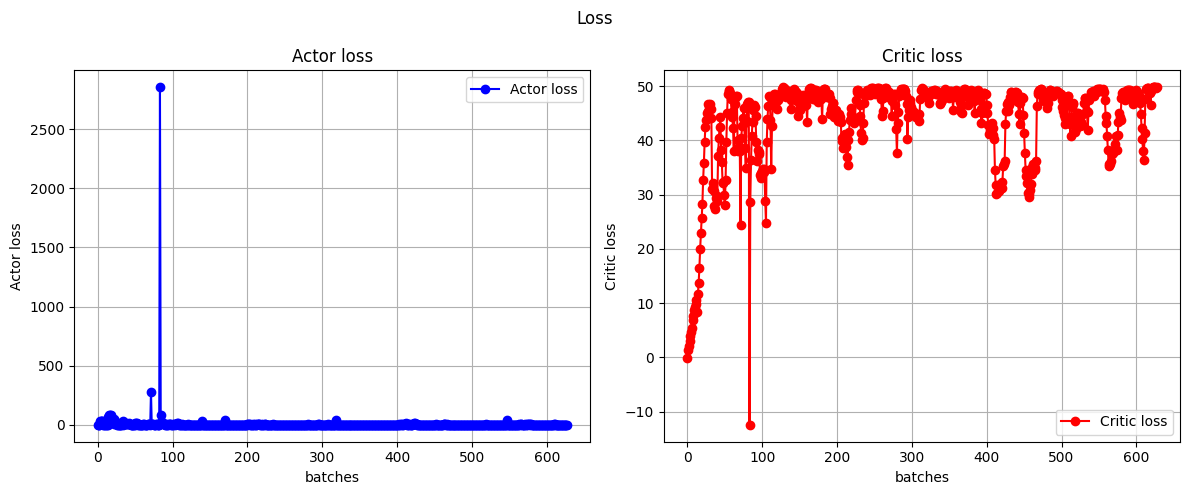

<Figure size 640x480 with 0 Axes>

In [68]:
plot_split_tuples(
    split_loss,
    title="Loss",
    ylabel1="Actor loss",
    ylabel2="Critic loss",
    version=2
)

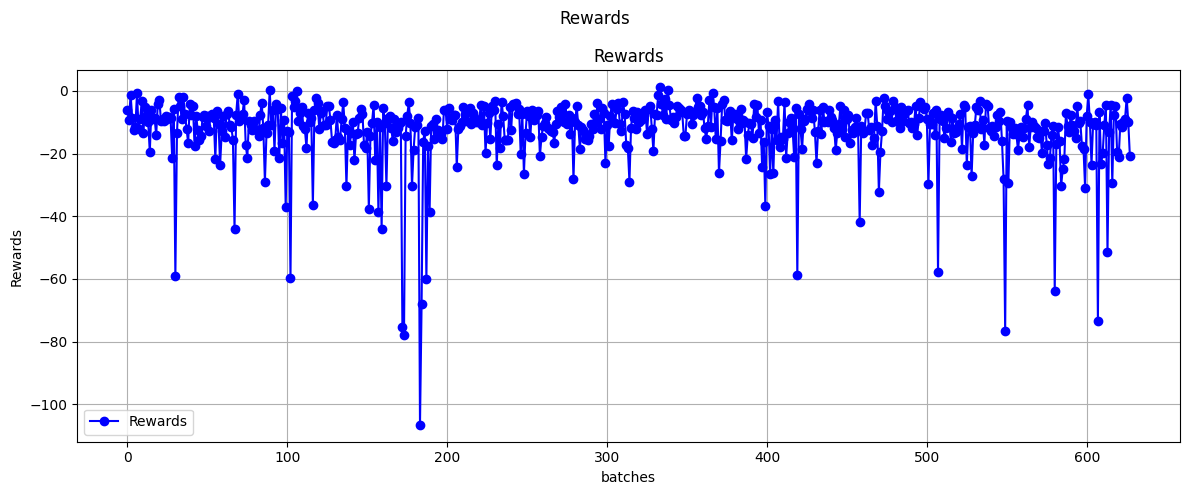

<Figure size 640x480 with 0 Axes>

In [69]:
plot_split_tuples(
    all_rewards,
    title="Rewards",
    ylabel1="Rewards",
    version=2,
    is_pair=False
)

In [64]:
split_loss = []
split_reward = []

In [65]:
for idx in range(0, len(all_loss)):
    if (idx + 1) % 1024 == 0:
        split_loss.append(all_loss[idx])

for idx in range(0, len(all_rewards)):
    if (idx + 1) % 1024 == 0:
        split_reward.append(all_rewards[idx])

In [66]:
np.argmax(all_rewards)

np.int64(333)

# Testing

Test the model on the environment and get a cool video

In [305]:
saving_steps = 1000

In [306]:
saving_env = gym.make_vec("BipedalWalker-v3", hardcore=False, render_mode="rgb_array_list", num_envs=1)

In [307]:
def save_gameplay(
    model: tf.keras.Model,
    max_steps: int = 1000,
    env: gym.Env | None = None,
):
    save_buffer = ReplayBuffer(
        max_size=buffer_size,
        observation_space=train_env.single_observation_space,
        action_space=train_env.single_action_space
    )
    
    _ = play_game(
        model=model,
        env=env,
        steps=max_steps,
        buffer=save_buffer
    )

    render = env.render()

    gym.utils.save_video.save_video(
        frames=render[0],
        video_folder="videos",
        fps=env.metadata["render_fps"],
    )

    return render

In [308]:
res = save_gameplay(actor_model, max_steps=saving_steps, env=saving_env)